In [1]:
# set path
import os
import sys
my_path = os.path.abspath(os.path.dirname('.'))
path = os.path.join(my_path, "..")
sys.path.insert(1, path)

In [2]:
# load modules
import pandas as pd
from extract import extracted_data_analyzer as eda, aact_querier as aq
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import psycopg2
import getpass
import pandas.io.sql as psql
import plotly.express as px
import imageio
import pycountry as pc
from plotly.offline import iplot
from matplotlib.pyplot import *
import bar_chart_race as bcr

In [3]:
#configs
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


In [4]:
## Functions for data exploration and visualization

In [5]:
def ctgov_data_prep(df):
    # Rename and format columns
    if '#nct_id' in df.columns:
        df.rename(columns={'#nct_id':'nct_id'}, inplace=True)
        
    if 'start_date' in df.columns:
        df['start_datetime']=pd.to_datetime(df['start_date'], format='%Y-%m-%d')
        df['start_year'] = df['start_datetime'].dt.to_period('Y')

In [6]:
# https://peps.python.org/pep-0484/
def img_to_gif(filenames: list, gif_path: str):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images, fps=1.75)

In [7]:
import re

def camelize(string):
    output = ''.join(x for x in string.title() if x.isalnum())
    return output[0].lower() + output[1:]

def snakify(string):
    name=camelize(string)
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

print(snakify("Clinical Trial Site Count by Country: 2021"))

clinical_trial_site_count_by_country2021


In [8]:
def choropleth(df, year: int):

    sites_df=df[df.start_datetime.dt.year==year]['country_alpha_3'].value_counts().reset_index()
    sites_df.columns=['country','values']

    # df = px.data.gapminder().query("year==2007")
    fig = px.choropleth(sites_df, locations="country",
                        color=np.log10(sites_df["values"]), 
                        hover_name="country",
                        color_continuous_scale='Reds')

    # log https://community.plotly.com/t/how-to-make-a-logarithmic-color-scale-in-my-choropleth-map/35010/4
    fig.update_layout(coloraxis_colorbar=dict(len=0.75,
                      title='# of Trial-Sites', 
                      tickvals = [0, 1, 2, 3, 3.699, 4],
                      ticktext = ['1', '10', '100', '1000', '5000','10000'],                                  

    ),
                                              legend=dict(yanchor='middle', xanchor='right', x=3
        # bbox_to_anchor=(0.6,0.5)
        )   
                     
                     )
    
    title="Cancer Research Site Count by Country: "+str(year)
    
    fig.update_layout(
        title={
            'text' : title,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'bottom'
        }
        # geo_scope='usa', # limit map scope to USA
    )
    

    
    filename=snakify(title)+".png"
    
    filepath="./visuals/"+filename
    fig.write_image(filepath)

    # log transform colors
    # fig.update_geos(fitbounds="locations", visible=False)
    # fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    # fig.show()

    iplot(fig,validate=False, filename=filepath)
    
    return filepath
    # plot(fig, validate=False, filename='d3-world-map.html', image='png')

In [9]:
def get_country_alpha_2(country_name):
    manual_map={'Taiwan':'TW',
               'Czech Republic':'CZ',
               'Vietnam':'VN',
               'Venezuela':'VE',
                'Tanzania':'TZ',
                'Macedonia':'MK',
                'Former Serbia and Montenegro':'CS',
                'Palestinian Territory, occupied':'PS',
                'Swaziland':'SZ',
                'Yugoslavia':'YU',
                'Bolivia':'BO',
                'Kosovo':'XK',
                'Virgin Islands (U.S.)':'VI'
               }
    try:
        alpha_2=pc.countries.get(name=country_name).alpha_2
    except:
        alpha_2=manual_map.get(country_name, 'Null')

    
    return alpha_2

def get_country_alpha_3(country_name):
    manual_map={'Taiwan':'TWN',
               'Czech Republic':'CZE',
               'Vietnam':'VNM',
               'Venezuela':'VEN',
                'Tanzania':'TZA',
                'Macedonia':'MKD',
                'Macedonia, The Former Yugoslav Republic of':'MKD',
                'Former Serbia and Montenegro':'SCG',
                'Palestinian Territory, occupied':'PSE',
                'Swaziland':'SWZ',
                'Yugoslavia':'YUG',
                'Former Yugoslavia':'YUG',
                'Bolivia':'BOL',
                'Kosovo':'XKX',
                'Virgin Islands (U.S.)':'VIR'
               }
    try:
        alpha_3=pc.countries.get(name=country_name).alpha_3
    except:
        alpha_3=manual_map.get(country_name, 'Null')

    
    return alpha_3

In [10]:
# Get cancer trial sites
# trial_sites=aq.query_aact(aq.get_cancer_trial_sites())
trial_sites=pd.read_csv(path+"/extract/extracted_data/cancer_trials_sites.csv", index_col=0)

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.



In [11]:
trial_sites.head()

nct_id                                              title  \
0  NCT00000105  Vaccination With Tetanus and KLH to Assess Imm...   
1  NCT00000124         Collaborative Ocular Melanoma Study (COMS)   
2  NCT00000589  Trial to Reduce Alloimmunization to Platelets ...   
3  NCT00000591  T-Cell Depletion in Unrelated Donor Marrow Tra...   
4  NCT00000603  Cord Blood Stem Cell Transplantation Study (CO...   

   has_us_facility  start_date  overall_status    phase  enrollment  \
0             True  2002-07-31      Terminated      NaN       112.0   
1            False  1986-11-30  Unknown status  Phase 3         NaN   
2            False  1989-08-31       Completed  Phase 3         NaN   
3            False  1993-11-30       Completed  Phase 3         NaN   
4            False  1996-09-30       Completed  Phase 2         NaN   

  enrollment_type      study_type  number_of_arms  number_of_groups  \
0          Actual   Observational             NaN               3.0   
1             NaN  Interventional             NaN               NaN   
2             NaN  Interventional             NaN               NaN   
3             NaN  Interventional             NaN               NaN   
4             NaN  Interventional             NaN               NaN   

                  why_stopped has_dmc is_fda_regulated_drug  \
0  Replaced by another study.    True                   NaN   
1                         NaN     NaN                   NaN   
2                         NaN     NaN                   NaN   
3                         NaN     NaN                   NaN   
4                         NaN     NaN                   NaN   

  is_fda_regulated_device is_unapproved_device  is_ppsd is_us_export  \
0                     NaN                  NaN      NaN          NaN   
1                     NaN                  NaN      NaN          NaN   
2                     NaN                  NaN      NaN          NaN   
3                     NaN                  NaN      NaN          NaN   
4                     NaN                  NaN      NaN          NaN   

   facility_id                                      facility_name  \
0   49295977.0  Division of Hematology, Oncology, and Transpla...   
1          NaN                                                NaN   
2          NaN                                                NaN   
3          NaN                                                NaN   
4          NaN                                                NaN   

  facility_status facility_city facility_state facility_zip facility_country  
0             NaN   Minneapolis      Minnesota        55455    United States  
1             NaN           NaN            NaN          NaN              NaN  
2             NaN           NaN            NaN          NaN              NaN  
3             NaN           NaN            NaN          NaN              NaN  
4             NaN           NaN            NaN          NaN              NaN

In [38]:
trial_sites[trial_sites['facility_state']=='Minnesota'].facility_name.value_counts().head(25)

Mayo Clinic                                   1032
Mayo Clinic Cancer Center                      531
United Hospital                                487
Mayo Clinic in Rochester                       477
Fairview Ridges Hospital                       461
Ridgeview Medical Center                       450
Fairview Southdale Hospital                    387
Regions Hospital                               341
CCOP - Metro-Minnesota                         336
Abbott-Northwestern Hospital                   320
Park Nicollet Clinic - Saint Louis Park        319
Mercy Hospital                                 318
Unity Hospital                                 307
Hennepin County Medical Center                 303
Lakeview Hospital                              301
Minnesota Oncology Hematology PA-Maplewood     296
North Memorial Medical Health Center           288
Saint John's Hospital - Healtheast             287
Saint Francis Regional Medical Center          284
Rice Memorial Hospital         

In [12]:
trial_sites.nct_id.nunique()

82107

In [13]:
# trial_sites.to_csv(path+"/extract/extracted_data/cancer_trials_sites.csv")

In [ ]:
img_to_gif(filenames, './visuals/clinical_trial_site_count_by_country.gif')

In [13]:
# Clean site data
ctgov_data_prep(trial_sites)
trial_sites['facility_country'].fillna('Null', inplace=True)
trial_sites['country_alpha_2']=trial_sites.facility_country.apply(lambda x: get_country_alpha_2(x))
trial_sites['country_alpha_3']=trial_sites.facility_country.apply(lambda x: get_country_alpha_3(x))

In [14]:
trial_sites[trial_sites['country_alpha_3']=='Null'].facility_country.value_counts()

Null                      6514
Libyan Arab Jamahiriya       1
Name: facility_country, dtype: int64

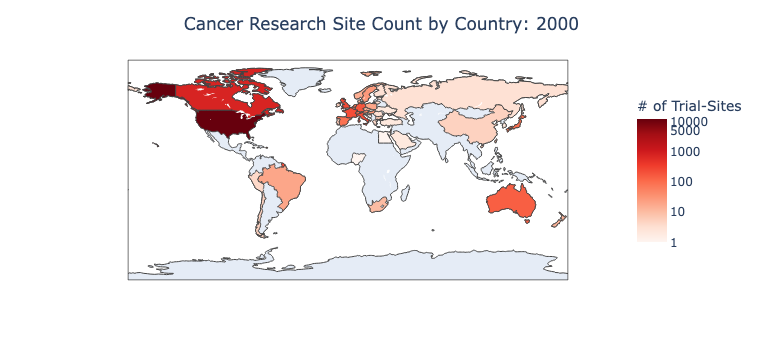

'./visuals/cancer_research_site_count_by_country2000.png'

In [15]:
choropleth(trial_sites, 2000)

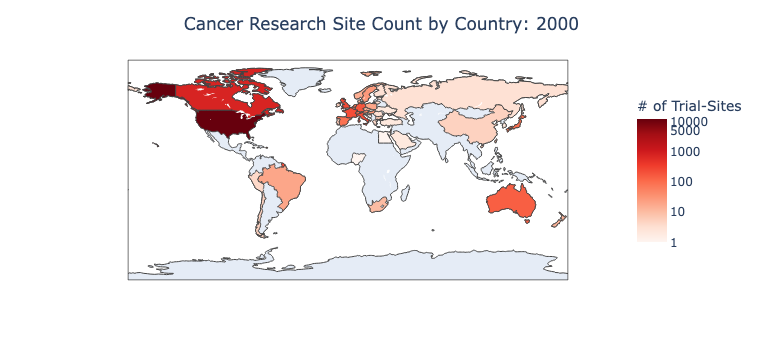

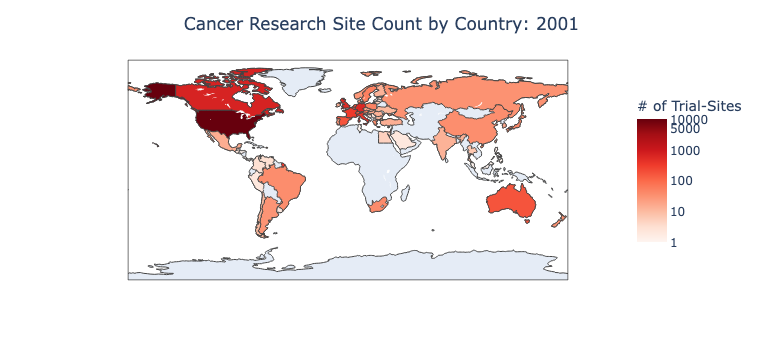

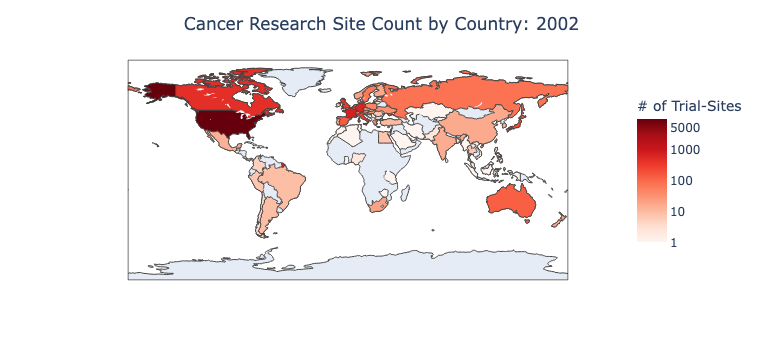

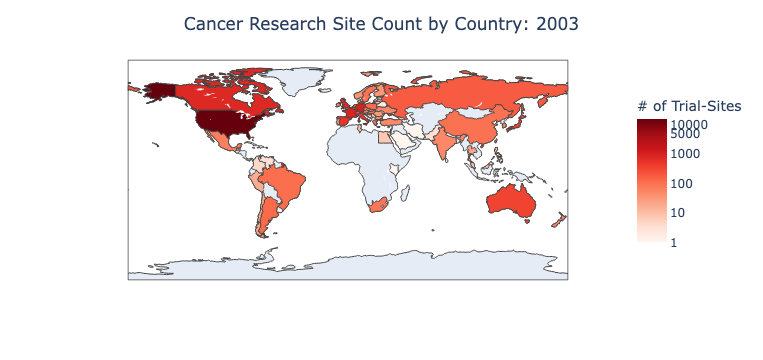

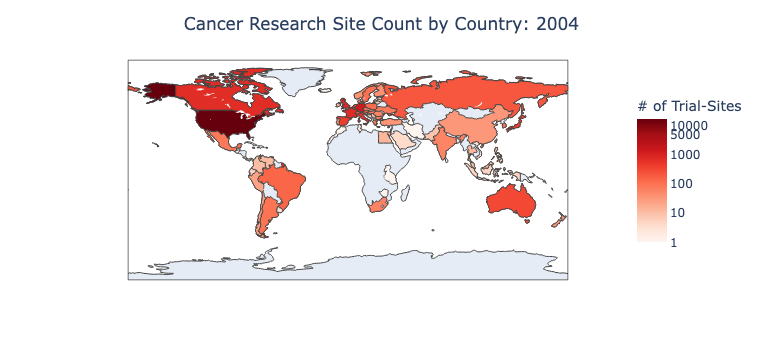

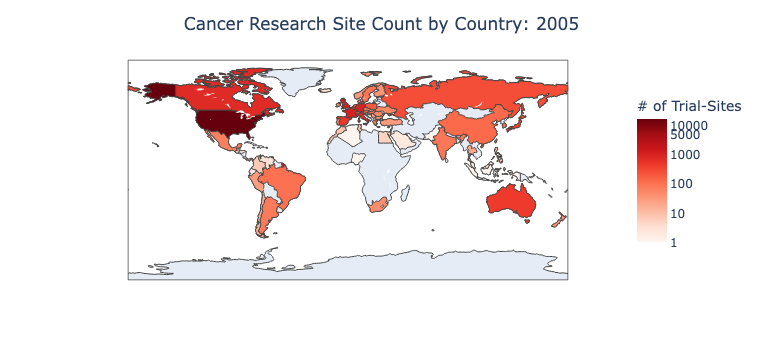

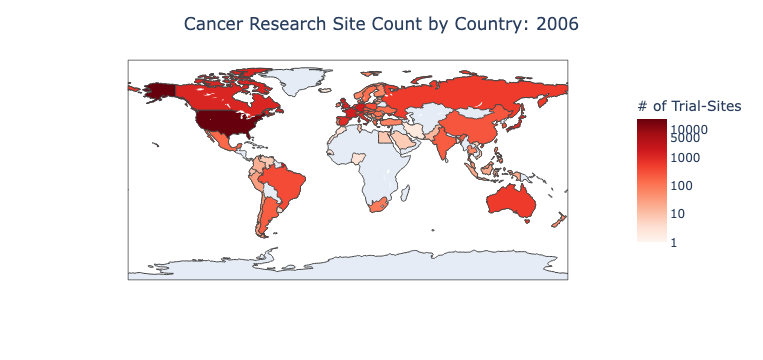

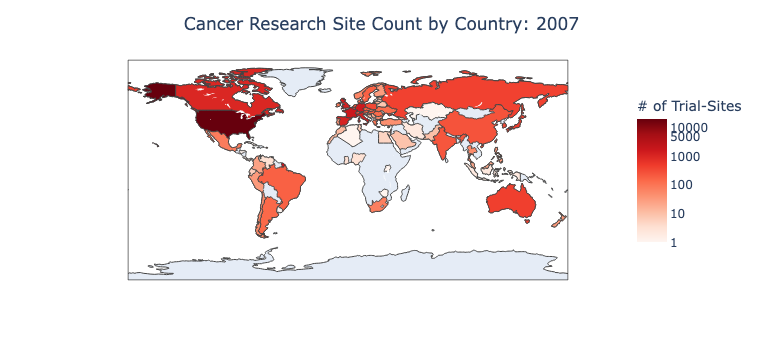

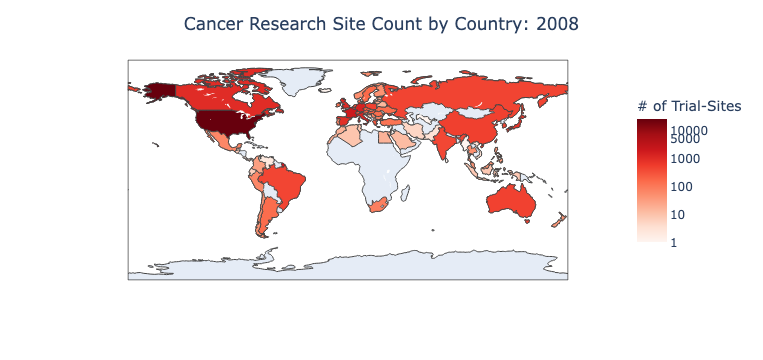

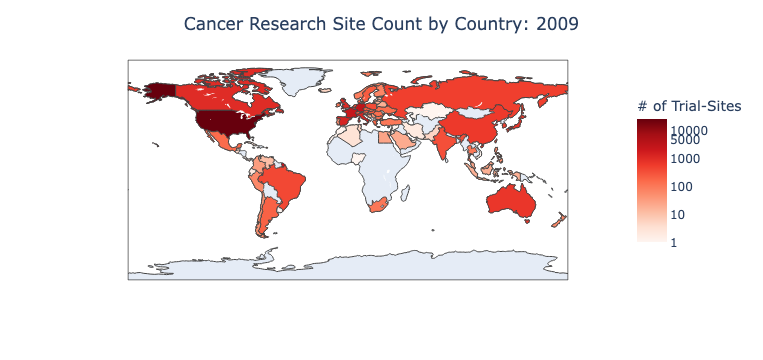

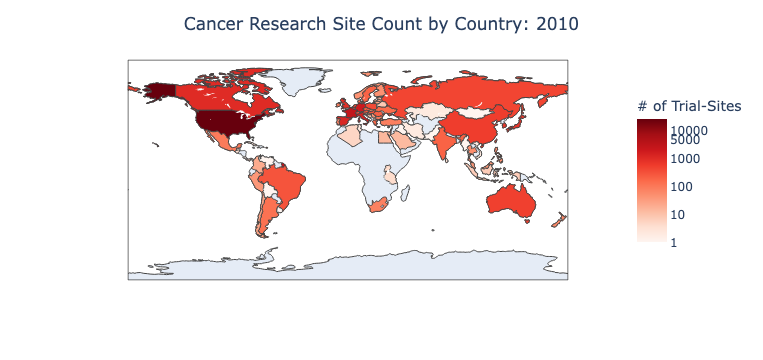

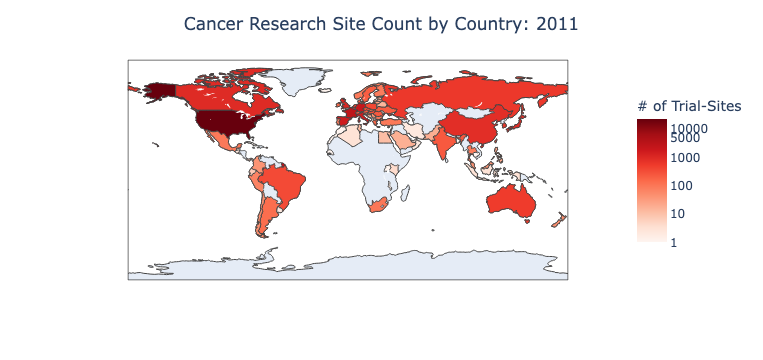

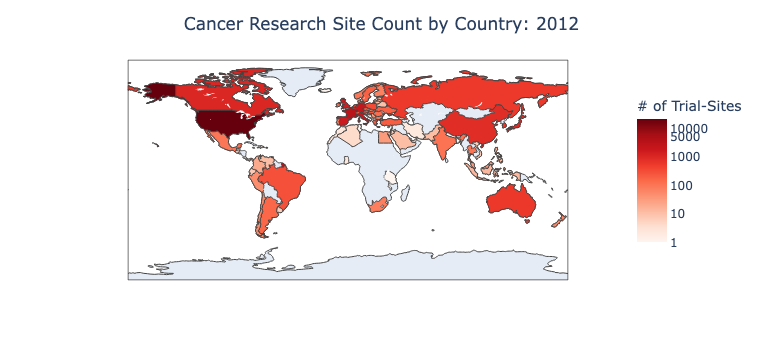

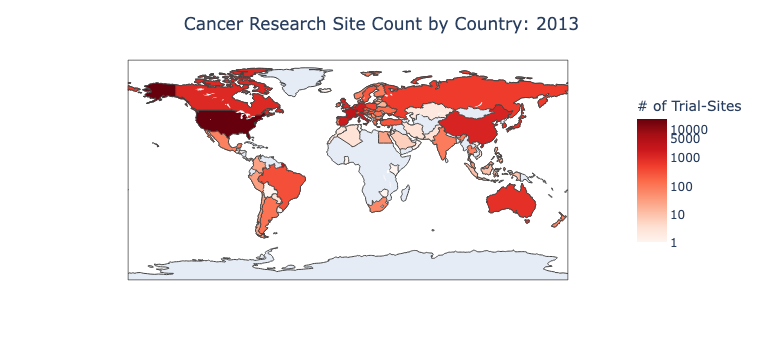

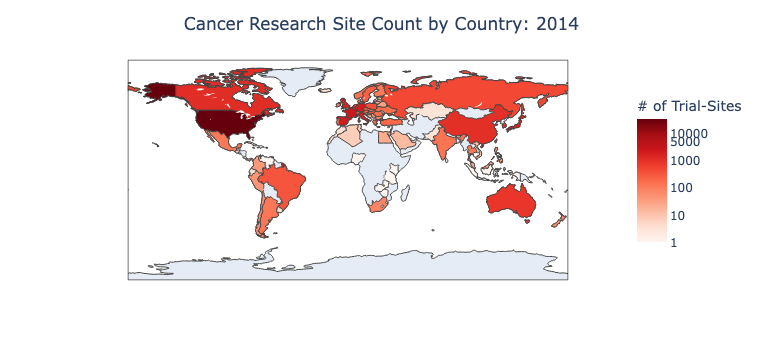

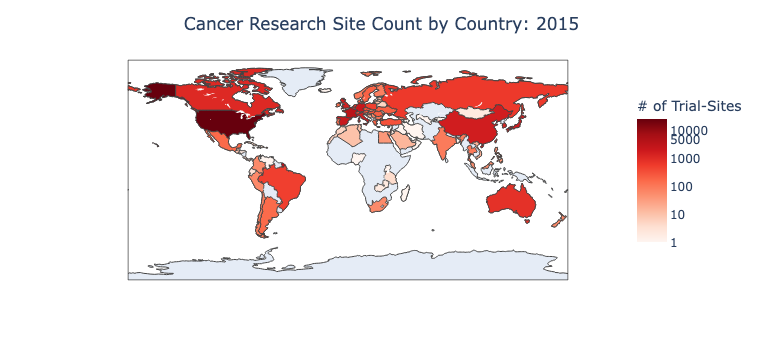

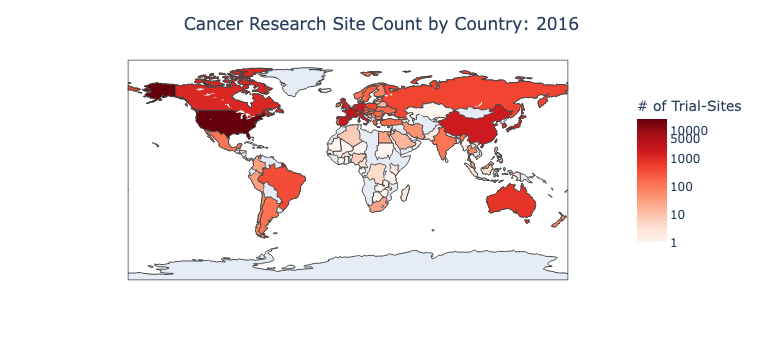

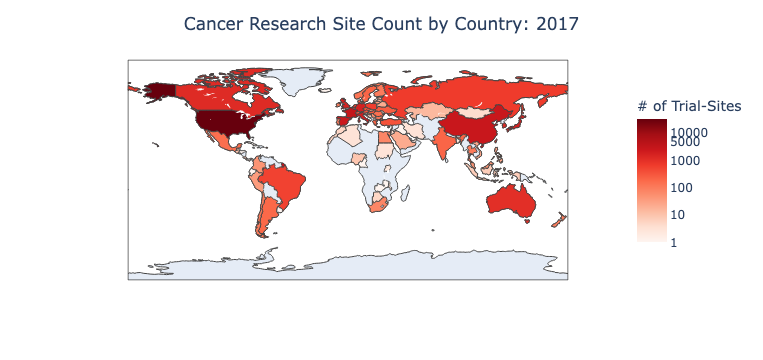

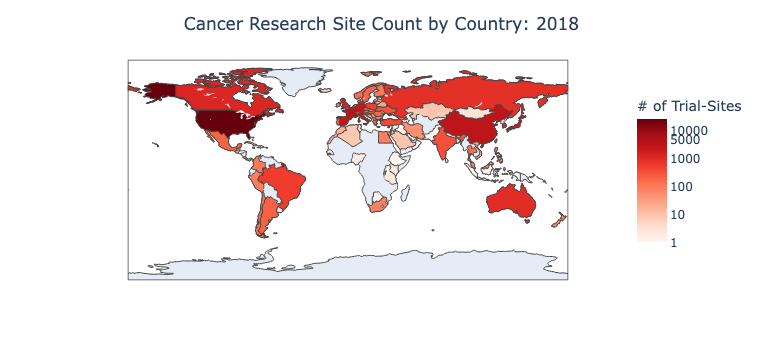

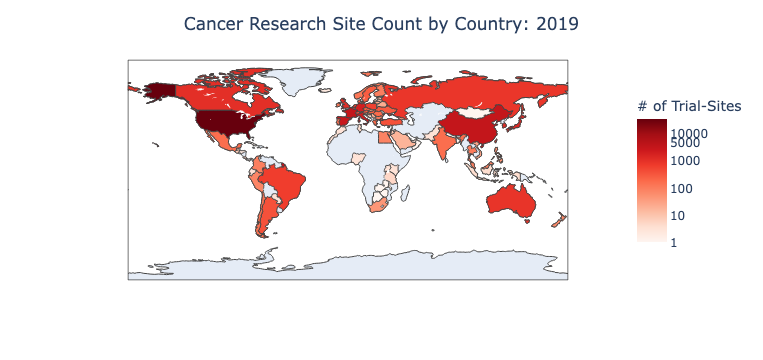

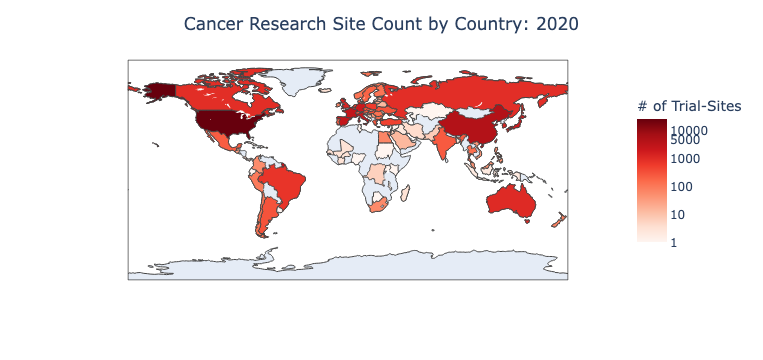

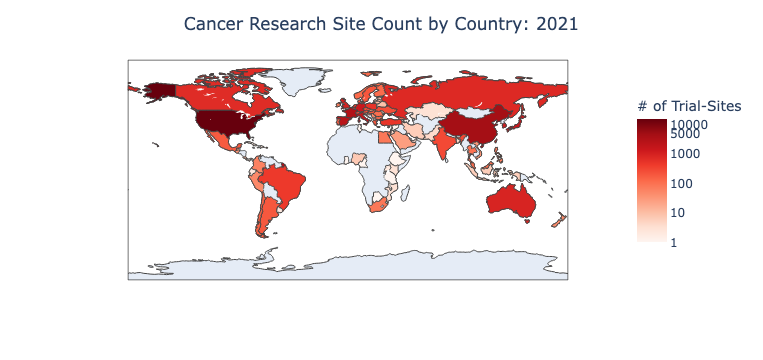

In [16]:
# Create trial site volume map by year
filenames=[]

for x in range(2000,2022):
    filenames.append(choropleth(trial_sites, x))

In [17]:
img_to_gif(filenames, './visuals/clinical_trial_site_count_by_country.gif')

In [18]:
site_countries_by_year=trial_sites[(trial_sites.start_datetime.dt.year>=2000)&(trial_sites.start_datetime.dt.year<=2021)].groupby(['start_year','country_alpha_3']).size().reset_index(name='counts')

In [19]:
site_countries_by_year.head()

start_year country_alpha_3  counts
0       2000             AUS     143
1       2000             AUT      42
2       2000             BEL      56
3       2000             BGR       6
4       2000             BIH       1

In [20]:
site_countries_pivot=site_countries_by_year.pivot(index='start_year', columns='country_alpha_3', values='counts').reset_index().fillna(0)

In [21]:
site_countries_pivot

country_alpha_3 start_year  ALB  ARE    ARG  ARM  ASM     AUS    AUT  AZE  \
0                     2000  0.0  0.0    0.0  0.0  0.0   143.0   42.0  0.0   
1                     2001  0.0  0.0   30.0  0.0  0.0   175.0   54.0  0.0   
2                     2002  0.0  1.0    9.0  0.0  0.0   128.0   35.0  0.0   
3                     2003  0.0  0.0  118.0  0.0  0.0   332.0   46.0  0.0   
4                     2004  1.0  0.0   90.0  0.0  0.0   308.0  176.0  0.0   
5                     2005  0.0  0.0   80.0  0.0  0.0   440.0  129.0  0.0   
6                     2006  1.0  0.0  218.0  0.0  0.0   554.0  301.0  0.0   
7                     2007  0.0  0.0  144.0  0.0  0.0   440.0  223.0  0.0   
8                     2008  0.0  0.0  142.0  0.0  0.0   476.0  184.0  0.0   
9                     2009  0.0  3.0  204.0  0.0  0.0   704.0  245.0  0.0   
10                    2010  0.0  0.0  125.0  0.0  0.0   493.0  261.0  0.0   
11                    2011  2.0  3.0  132.0  0.0  0.0   509.0  205.0  0.0   
12                    2012  1.0  4.0  153.0  0.0  0.0   556.0  242.0  0.0   
13                    2013  0.0  0.0  115.0  0.0  0.0   813.0  224.0  0.0   
14                    2014  0.0  1.0  119.0  0.0  0.0   800.0  230.0  0.0   
15                    2015  0.0  3.0  157.0  1.0  0.0   831.0  271.0  1.0   
16                    2016  0.0  0.0  123.0  0.0  0.0   734.0  173.0  0.0   
17                    2017  0.0  2.0  182.0  1.0  0.0  1031.0  292.0  0.0   
18                    2018  1.0  1.0  206.0  0.0  0.0   951.0  219.0  0.0   
19                    2019  0.0  3.0  372.0  0.0  0.0   903.0  266.0  0.0   
20                    2020  0.0  1.0  306.0  0.0  2.0  1070.0  240.0  0.0   
21                    2021  1.0  4.0  197.0  2.0  0.0   914.0  240.0  1.0   

country_alpha_3  BDI    BEL  BFA  BGD    BGR  BHR  BHS   BIH   BLR  BLZ  BOL  \
0                0.0   56.0  0.0  0.0    6.0  0.0  0.0   1.0   0.0  0.0  0.0   
1                0.0  137.0  0.0  0.0   10.0  0.0  0.0   2.0   0.0  0.0  0.0   
2                0.0  149.0  0.0  3.0    3.0  0.0  0.0   1.0   0.0  0.0  0.0   
3                0.0  234.0  0.0  0.0   30.0  0.0  0.0   4.0   2.0  1.0  0.0   
4                0.0  340.0  0.0  0.0   58.0  0.0  0.0   3.0   0.0  0.0  0.0   
5                0.0  262.0  0.0  0.0   39.0  0.0  0.0   2.0   0.0  0.0  0.0   
6                0.0  339.0  0.0  4.0   87.0  0.0  0.0  12.0   0.0  0.0  0.0   
7                0.0  364.0  0.0  0.0   48.0  0.0  0.0   8.0   8.0  0.0  0.0   
8                0.0  480.0  0.0  0.0   62.0  0.0  0.0   6.0  14.0  0.0  0.0   
9                0.0  540.0  0.0  0.0  107.0  0.0  4.0  14.0  18.0  0.0  0.0   
10               0.0  486.0  0.0  0.0   85.0  0.0  1.0   9.0   8.0  0.0  1.0   
11               0.0  655.0  0.0  1.0   81.0  0.0  1.0  14.0  14.0  0.0  0.0   
12               0.0  575.0  0.0  1.0   94.0  1.0  1.0   2.0  10.0  0.0  0.0   
13               0.0  695.0  0.0  0.0   60.0  0.0  0.0  14.0  17.0  0.0  1.0   
14               0.0  669.0  0.0  0.0   67.0  0.0  0.0  12.0  30.0  0.0  0.0   
15               0.0  677.0  0.0  1.0   97.0  0.0  0.0  13.0   5.0  0.0  0.0   
16               0.0  517.0  2.0  1.0   74.0  0.0  0.0   9.0  15.0  0.0  0.0   
17               0.0  676.0  0.0  2.0  104.0  0.0  0.0   6.0  22.0  0.0  0.0   
18               1.0  721.0  0.0  3.0   70.0  0.0  0.0   8.0  28.0  0.0  0.0   
19               0.0  694.0  0.0  1.0   91.0  0.0  0.0   4.0  22.0  0.0  0.0   
20               0.0  658.0  3.0  2.0  123.0  0.0  0.0   6.0  13.0  0.0  0.0   
21               0.0  560.0  0.0  4.0  109.0  0.0  0.0   0.0   9.0  0.0  0.0   

country_alpha_3    BRA  BRB  BRN  BWA     CAN    CHE    CHL     CHN  CIV  CMR  \
0                 19.0  0.0  0.0  0.0   747.0   78.0    5.0     5.0  0.0  0.0   
1                 37.0  0.0  0.0  0.0   711.0  114.0   10.0    36.0  0.0  0.0   
2                  9.0  0.0  0.0  0.0   453.0   49.0    3.0    16.0  0.0  0.0   
3                108.0  0.0  0.0  0.0   751.0  136.0   16.0    

In [22]:
site_countries_pivot.index=site_countries_pivot.start_year.dt.year
site_countries_pivot.head()

country_alpha_3 start_year  ALB  ARE    ARG  ARM  ASM    AUS    AUT  AZE  BDI  \
start_year                                                                      
2000                  2000  0.0  0.0    0.0  0.0  0.0  143.0   42.0  0.0  0.0   
2001                  2001  0.0  0.0   30.0  0.0  0.0  175.0   54.0  0.0  0.0   
2002                  2002  0.0  1.0    9.0  0.0  0.0  128.0   35.0  0.0  0.0   
2003                  2003  0.0  0.0  118.0  0.0  0.0  332.0   46.0  0.0  0.0   
2004                  2004  1.0  0.0   90.0  0.0  0.0  308.0  176.0  0.0  0.0   

country_alpha_3    BEL  BFA  BGD   BGR  BHR  BHS  BIH  BLR  BLZ  BOL    BRA  \
start_year                                                                    
2000              56.0  0.0  0.0   6.0  0.0  0.0  1.0  0.0  0.0  0.0   19.0   
2001             137.0  0.0  0.0  10.0  0.0  0.0  2.0  0.0  0.0  0.0   37.0   
2002             149.0  0.0  3.0   3.0  0.0  0.0  1.0  0.0  0.0  0.0    9.0   
2003             234.0  0.0  0.0  30.0  0.0  0.0  4.0  2.0  1.0  0.0  108.0   
2004             340.0  0.0  0.0  58.0  0.0  0.0  3.0  0.0  0.0  0.0  136.0   

country_alpha_3  BRB  BRN  BWA    CAN    CHE   CHL   CHN  CIV  CMR  COD   COL  \
start_year                                                                      
2000             0.0  0.0  0.0  747.0   78.0   5.0   5.0  0.0  0.0  0.0   0.0   
2001             0.0  0.0  0.0  711.0  114.0  10.0  36.0  0.0  0.0  0.0   3.0   
2002             0.0  0.0  0.0  453.0   49.0   3.0  16.0  0.0  0.0  0.0   5.0   
2003             0.0  0.0  0.0  751.0  136.0  16.0  95.0  0.0  0.0  0.0   4.0   
2004             0.0  0.0  0.0  699.0  144.0  23.0  32.0  0.0  0.0  0.0  10.0   

country_alpha_3  CRI  CUB  CYP   CZE     DEU   DNK  DOM  DZA  ECU   EGY  \
start_year                                                                
2000             0.0  0.0  0.0  11.0   174.0  11.0  0.0  0.0  0.0   1.0   
2001             1.0  0.0  3.0  14.0   604.0  25.0  0.0  0.0  0.0   5.0   
2002             2.0  0.0  0.0  30.0   618.0  22.0  0.0  1.0  0.0   7.0   
2003             0.0  0.0  0.0  73.0  1002.0  45.0  0.0  0.0  0.0   7.0   
2004             3.0  0.0  1.0  62.0  1360.0  53.0  0.0  0.0  5.0  13.0   

country_alpha_3    ESP  EST  ETH   FIN  FJI    FRA  FRO  GAB    GBR  GEO  GHA  \
start_year                                                                      
2000              86.0  2.0  0.0   3.0  0.0  220.0  0.0  0.0  241.0  0.0  0.0   
2001             172.0  3.0  0.0  13.0  0.0  331.0  0.0  0.0  551.0  0.0  0.0   
2002             143.0  4.0  0.0  17.0  0.0  740.0  0.0  0.0  314.0  0.0  1.0   
2003             517.0  9.0  0.0  32.0  0.0  868.0  0.0  0.0  735.0  1.0  0.0   
2004             411.0  6.0  0.0  39.0  0.0  741.0  0.0  0.0  779.0  2.0  0.0   

country_alpha_3  GLP  GMB   GRC  GTM  GUM   HKG  HND   HRV  HTI   HUN  IDN  \
start_year                                                                   
2000             0.0  0.0   4.0  0.0  0.0   2.0  0.0   2.0  0.0  30.0  0.0   
2001             0.0  0.0  37.0  2.0  0.0   6.0  1.0   5.0  0.0  17.0  0.0   
2002             0.0  0.0  33.0  1.0  0.0   8.0  0.0   2.0  0.0  30.0  1.0   
2003             0.0  0.0  85.0  4.0  0.0  10.0  0.0  17.0  0.0  88.0  0.0   
2004             0.0  0.0  72.0  2.0  0.0  15.0  0.0  16.0  0.0  73.0  5.0   

country_alpha_3   IND   IRL  IRN  IRQ  ISL   ISR    ITA  JAM  JOR    JPN  KAZ  \
start_year                                                                      
2000              0.0   5.0  0.0  0.0  0.0  13.0  234.0  0.0  0.0   92.0  0.0   
2001             13.0  13.0  0.0  0.0  0.0  52.0  422.0  1.0  0.0   41.0  0.0   
2002             15.0   6.0  1.0  0.0  0.0  39.0  319.0  0.0  0.0  202.0  1.0   
2003             50.0  59.0  1.0  0.0  0.0  76.0  527.0  0.0  0.0  344.0  0.0   
2004             57.0  13.0  1.0  0.0  1.0  65.0  577.0  1.0  0.0  402.0  0.0   

country_alpha_3  KEN  KGZ  KHM   KOR  KWT  LBN  LKA   LTU  LUX   LVA  MAR  \
start_year              

In [23]:
site_countries_pivot.drop(columns=['start_year'], inplace=True)

In [24]:
site_countries_pivot.head()

country_alpha_3  ALB  ARE    ARG  ARM  ASM    AUS    AUT  AZE  BDI    BEL  \
start_year                                                                  
2000             0.0  0.0    0.0  0.0  0.0  143.0   42.0  0.0  0.0   56.0   
2001             0.0  0.0   30.0  0.0  0.0  175.0   54.0  0.0  0.0  137.0   
2002             0.0  1.0    9.0  0.0  0.0  128.0   35.0  0.0  0.0  149.0   
2003             0.0  0.0  118.0  0.0  0.0  332.0   46.0  0.0  0.0  234.0   
2004             1.0  0.0   90.0  0.0  0.0  308.0  176.0  0.0  0.0  340.0   

country_alpha_3  BFA  BGD   BGR  BHR  BHS  BIH  BLR  BLZ  BOL    BRA  BRB  \
start_year                                                                  
2000             0.0  0.0   6.0  0.0  0.0  1.0  0.0  0.0  0.0   19.0  0.0   
2001             0.0  0.0  10.0  0.0  0.0  2.0  0.0  0.0  0.0   37.0  0.0   
2002             0.0  3.0   3.0  0.0  0.0  1.0  0.0  0.0  0.0    9.0  0.0   
2003             0.0  0.0  30.0  0.0  0.0  4.0  2.0  1.0  0.0  108.0  0.0   
2004             0.0  0.0  58.0  0.0  0.0  3.0  0.0  0.0  0.0  136.0  0.0   

country_alpha_3  BRN  BWA    CAN    CHE   CHL   CHN  CIV  CMR  COD   COL  CRI  \
start_year                                                                      
2000             0.0  0.0  747.0   78.0   5.0   5.0  0.0  0.0  0.0   0.0  0.0   
2001             0.0  0.0  711.0  114.0  10.0  36.0  0.0  0.0  0.0   3.0  1.0   
2002             0.0  0.0  453.0   49.0   3.0  16.0  0.0  0.0  0.0   5.0  2.0   
2003             0.0  0.0  751.0  136.0  16.0  95.0  0.0  0.0  0.0   4.0  0.0   
2004             0.0  0.0  699.0  144.0  23.0  32.0  0.0  0.0  0.0  10.0  3.0   

country_alpha_3  CUB  CYP   CZE     DEU   DNK  DOM  DZA  ECU   EGY    ESP  \
start_year                                                                  
2000             0.0  0.0  11.0   174.0  11.0  0.0  0.0  0.0   1.0   86.0   
2001             0.0  3.0  14.0   604.0  25.0  0.0  0.0  0.0   5.0  172.0   
2002             0.0  0.0  30.0   618.0  22.0  0.0  1.0  0.0   7.0  143.0   
2003             0.0  0.0  73.0  1002.0  45.0  0.0  0.0  0.0   7.0  517.0   
2004             0.0  1.0  62.0  1360.0  53.0  0.0  0.0  5.0  13.0  411.0   

country_alpha_3  EST  ETH   FIN  FJI    FRA  FRO  GAB    GBR  GEO  GHA  GLP  \
start_year                                                                    
2000             2.0  0.0   3.0  0.0  220.0  0.0  0.0  241.0  0.0  0.0  0.0   
2001             3.0  0.0  13.0  0.0  331.0  0.0  0.0  551.0  0.0  0.0  0.0   
2002             4.0  0.0  17.0  0.0  740.0  0.0  0.0  314.0  0.0  1.0  0.0   
2003             9.0  0.0  32.0  0.0  868.0  0.0  0.0  735.0  1.0  0.0  0.0   
2004             6.0  0.0  39.0  0.0  741.0  0.0  0.0  779.0  2.0  0.0  0.0   

country_alpha_3  GMB   GRC  GTM  GUM   HKG  HND   HRV  HTI   HUN  IDN   IND  \
start_year                                                                    
2000             0.0   4.0  0.0  0.0   2.0  0.0   2.0  0.0  30.0  0.0   0.0   
2001             0.0  37.0  2.0  0.0   6.0  1.0   5.0  0.0  17.0  0.0  13.0   
2002             0.0  33.0  1.0  0.0   8.0  0.0   2.0  0.0  30.0  1.0  15.0   
2003             0.0  85.0  4.0  0.0  10.0  0.0  17.0  0.0  88.0  0.0  50.0   
2004             0.0  72.0  2.0  0.0  15.0  0.0  16.0  0.0  73.0  5.0  57.0   

country_alpha_3   IRL  IRN  IRQ  ISL   ISR    ITA  JAM  JOR    JPN  KAZ  KEN  \
start_year                                                                     
2000              5.0  0.0  0.0  0.0  13.0  234.0  0.0  0.0   92.0  0.0  0.0   
2001             13.0  0.0  0.0  0.0  52.0  422.0  1.0  0.0   41.0  0.0  0.0   
2002              6.0  1.0  0.0  0.0  39.0  319.0  0.0  0.0  202.0  1.0  0.0   
2003             59.0  1.0  0.0  0.0  76.0  527.0  0.0  0.0  344.0  0.0  1.0   
2004             13.0  1.0  0.0  1.0  65.0  577.0  1.0  0.0  402.0  0.0  0.0   

country_alpha_3  KGZ  KHM   KOR  KWT  LBN  LKA   LTU  LUX   LVA  MAR  MCO  \
start_year                                                        

In [25]:
# %%capture
# Make race chart
# https://www.dexplo.org/bar_chart_race/

df = site_countries_pivot

bcr.bar_chart_race(df, 
                   filename='trial_site_count_by_country_race.gif',
                   period_length=500,
                   fixed_max=True, fixed_order=False, n_bars=10,
                   figsize=(5, 3), period_fmt='Year: {x:.0f}',
                   title='Top 10 Countries by # of Cancer Research Sites',)

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 129 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 130 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 131 missing from current font.

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/matplotlib/back

In [26]:
year=2021
top=5

sites_year_x=site_countries_by_year[site_countries_by_year.start_year.dt.year==year].sort_values(by='counts', ascending=False)
sites_year_x.iloc[top:, sites_year_x.columns.get_loc('country_alpha_3')]='Other'
top_x=sites_year_x.groupby(['start_year','country_alpha_3']).sum().reset_index().sort_values(by='counts', ascending=False)
top_x.index=top_x.country_alpha_3
top_x.drop('start_year', axis=1, inplace=True)
top_x.drop('country_alpha_3', axis=1, inplace=True)


/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



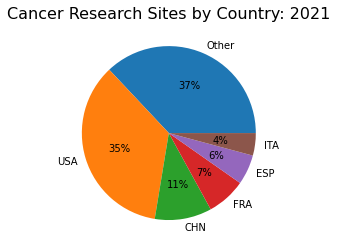

In [27]:
pie_title="Cancer Research Sites by Country: "+str(year)

plt.figure()
plt.pie(top_x, labels = top_x.index, autopct='%.0f%%')
plt.title(pie_title, fontsize=16)
filename=snakify(pie_title)
plt.savefig('./visuals/'+filename+'.png')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

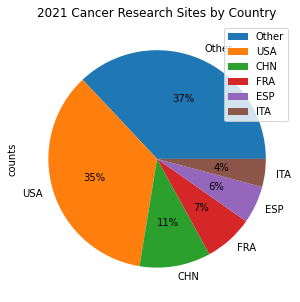

In [28]:
pie_title=str(year)+" Cancer Research Sites by Country"
plot = top_x.plot.pie(y='counts', title=pie_title, figsize=(5, 5), autopct='%.0f%%')
plot.savefig('./visuals/stacked_pie_country.png')
# pie_path="./visuals/stacked_pie_100_adfa"+str(year)+".png"
# plot.savefig(pie_path, bbox_inches='tight')

# pie_title="2021 Trials by "+collabel
# plt.pie(top_x.iloc[:, 1:], top_x.iloc[:, 1:].columns.tolist(), autopct='%.0f%%')
# plt.title(pie_title, fontsize=16)
# pie_path="./visuals/stacked_pie_100_"+colname+".png"
# plt.savefig(pie_path, bbox_inches='tight')
# plt.show()